In [50]:
import numpy as np
import matplotlib.pyplot as plt
import psutil
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


# Load data
%store -r Y
%store -r X_arrayRol
%store -r selected_indexes

# Map the target values to binary labels
Y = Y.map({'S': 1, 'B': 0})
Y


0      0
1      0
2      1
3      1
4      0
      ..
557    1
558    0
559    0
560    1
561    1
Name: Condition, Length: 562, dtype: int64

In [ ]:
# List to store precision scores for SVM and Random Forest
prec_list_svm = []
prec_list_rf = []

# Tracking total memory usage difference
total_memory_diff_svm = 0
total_memory_diff_rf = 0

# Defining SVM hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel types
}


In [ ]:
# Iterating over the rolling windows and selected features
for x_roll, boolInd in zip(X_arrayRol, selected_indexes):
    print(x_roll.shape)
    print(boolInd.shape)
    
    # Spliting the data
    Xtrain, Xtest, Ytrain, Ytest = split(x_roll.values[:, boolInd], Y)
    print(f"X training shape: {Xtrain.shape}\n")
    print(f"Notice that we reduced the number of features from {x_roll.shape[1]} to {Xtrain.shape[1]}\n")
    
    # Tracking the number of features changed
    feature_change = x_roll.shape[1] - Xtrain.shape[1]
    print(f"Number of features reduced: {feature_change}")
    
    
    
    
    # --- SVM Model ---
    
    # Scaling the data for SVM performance
    scaler = StandardScaler()
    Xtrain_scaled = scaler.fit_transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)

    svm = SVC(random_state=0)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)

    # Measuring CPU and memory usage for SVM
    process = psutil.Process()
    initial_cpu = process.cpu_percent(interval=0.1)
    initial_memory = process.memory_info().rss / (1024 * 1024)  # in MB

    # Starting time for execution time tracking
    start_time_svm = time.time()

    # Fiting the model with GridSearchCV
    grid_search.fit(Xtrain_scaled, Ytrain)

    # Obtaining the best model from GridSearchCV
    best_svm = grid_search.best_estimator_

    # Making predictions and calculate precision score for SVM
    y_pred_svm = best_svm.predict(Xtest_scaled)
    prec_svm = precision_score(Ytest.values, y_pred_svm)
    print(f"\nSVM Precision score = {prec_svm:.4f}")
    prec_list_svm.append(prec_svm)


    # --- Random Forest Model ---
    rf = RandomForestClassifier(random_state=0, n_estimators=500)
    rf.fit(Xtrain, Ytrain)
    y_pred_rf = rf.predict(Xtest)

    # Calculate precision score for Random Forest
    prec_rf = precision_score(Ytest.values, y_pred_rf)
    print(f"RF Precision score = {prec_rf:.4f}\n")
    prec_list_rf.append(prec_rf)

    print('##########')


(562, 207)
(207,)
X training shape: (393, 10)

Notice that we reduced the number of features from 207 to 10

Number of features reduced: 197
Fitting 5 folds for each of 32 candidates, totalling 160 fits

SVM Precision score = 0.7475
RF Precision score = 0.7292

##########
(562, 69)
(69,)
X training shape: (393, 10)

Notice that we reduced the number of features from 69 to 10

Number of features reduced: 59
Fitting 5 folds for each of 32 candidates, totalling 160 fits

SVM Precision score = 0.7576
RF Precision score = 0.7071

##########
(562, 41)
(41,)
X training shape: (393, 10)

Notice that we reduced the number of features from 41 to 10

Number of features reduced: 31
Fitting 5 folds for each of 32 candidates, totalling 160 fits

SVM Precision score = 0.7037
RF Precision score = 0.6832

##########
(562, 20)
(20,)
X training shape: (393, 10)

Notice that we reduced the number of features from 20 to 10

Number of features reduced: 10
Fitting 5 folds for each of 32 candidates, totalling


Total memory usage difference for SVM: 0.00 MB

Total memory usage difference for RF: 0.00 MB



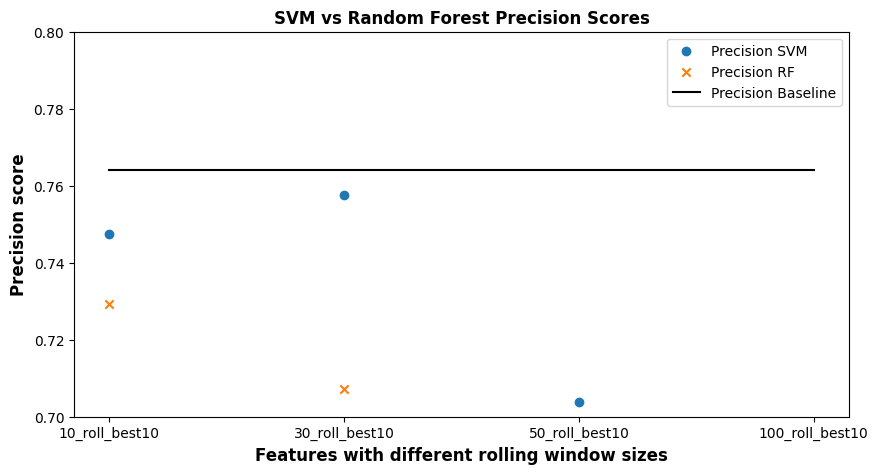

In [ ]:
# Print total memory usage differences
print(f"\nTotal memory usage difference for SVM: {total_memory_diff_svm:.2f} MB\n")
print(f"Total memory usage difference for RF: {total_memory_diff_rf:.2f} MB\n")

# Visualize the Precision scores for both models
plt.figure(figsize=(10, 5))

# Create strings for each feature set size
feature_sets = [10, 30, 50, 100]

# SVM Plot
plt.scatter([f"{s}_roll_best10" for s in feature_sets], prec_list_svm, label="Precision SVM", marker='o')

# Random Forest Plot
plt.scatter([f"{s}_roll_best10" for s in feature_sets], prec_list_rf, label="Precision RF", marker='x')


plt.plot([f"{s}_roll_best10" for s in feature_sets], [0.764] * len(prec_list_svm), label="Precision Baseline", color="black")

# Title and labels
plt.title("SVM vs Random Forest Precision Scores", fontweight='bold', fontsize=12)
plt.xlabel("Features with different rolling window sizes", fontweight='bold', fontsize=12)
plt.ylabel("Precision score", fontweight='bold', fontsize=12)
plt.ylim([0.7, 0.8])

# Show legend and plot
plt.legend()
plt.show()
